In [1]:
from load_data import load_data
from preprocess_data import preprocess_text

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report
from utils import *


In [3]:
df = load_data()


Train samples = 159571
Test cleaned samples = 63978


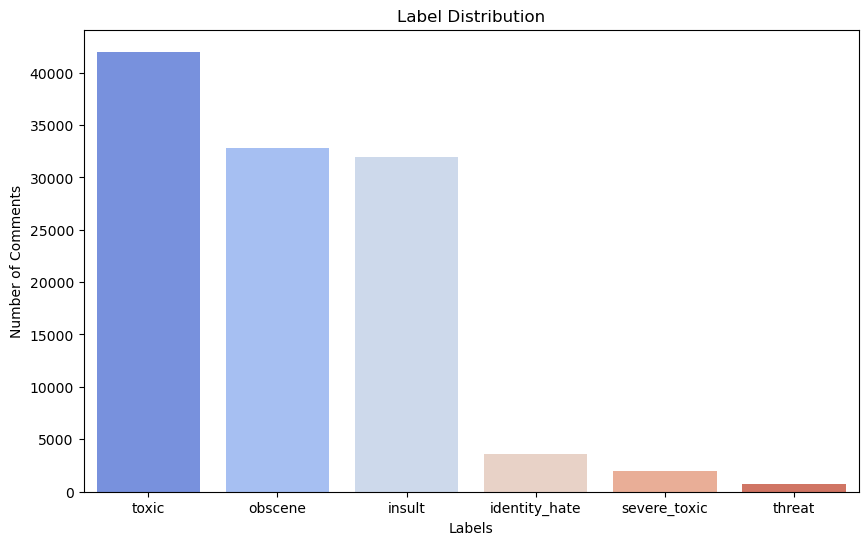

In [4]:
plot_label_distribution(df)

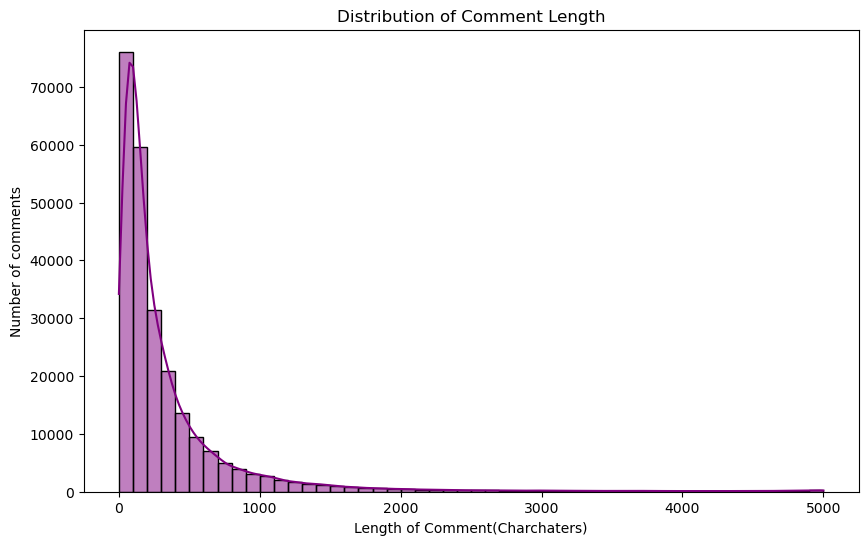

In [5]:
plot_comment_length(df)

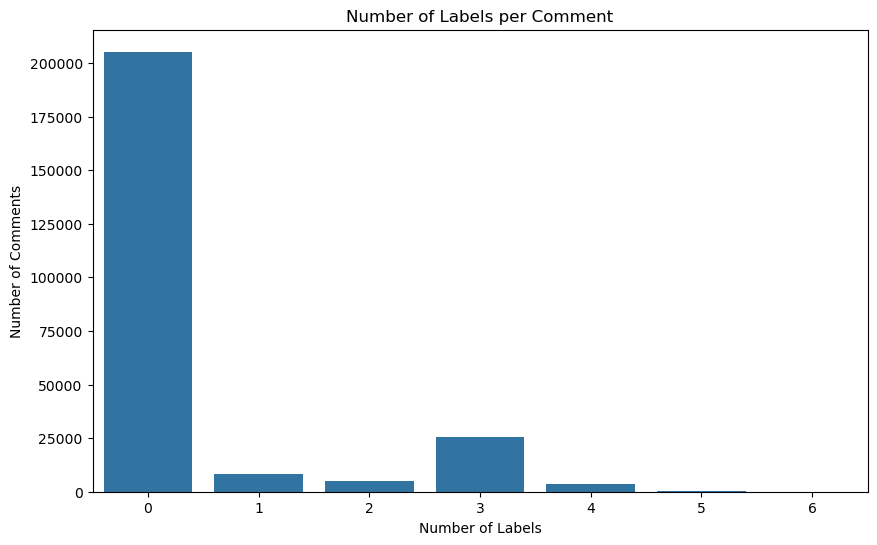

In [6]:
plot_labels_per_comment(df)

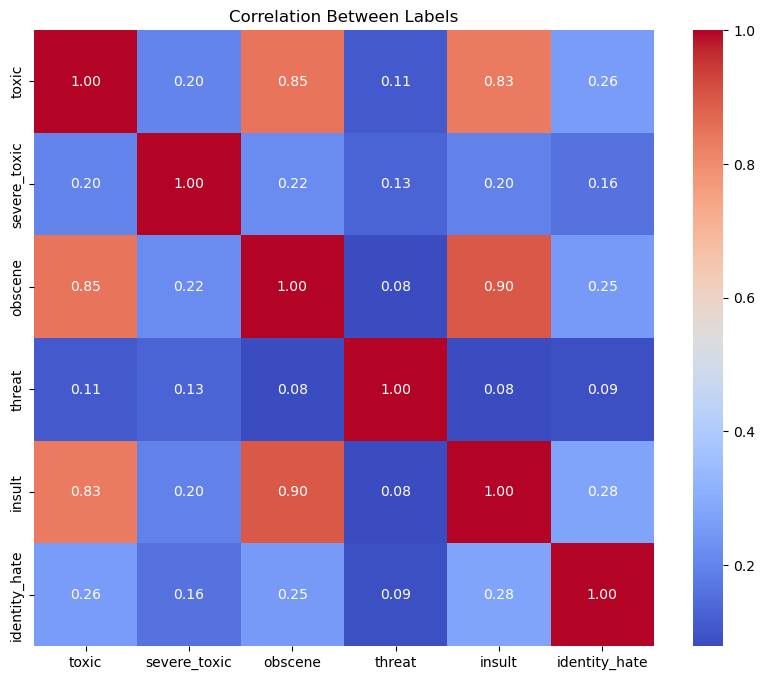

In [7]:
plot_label_correlation(df)

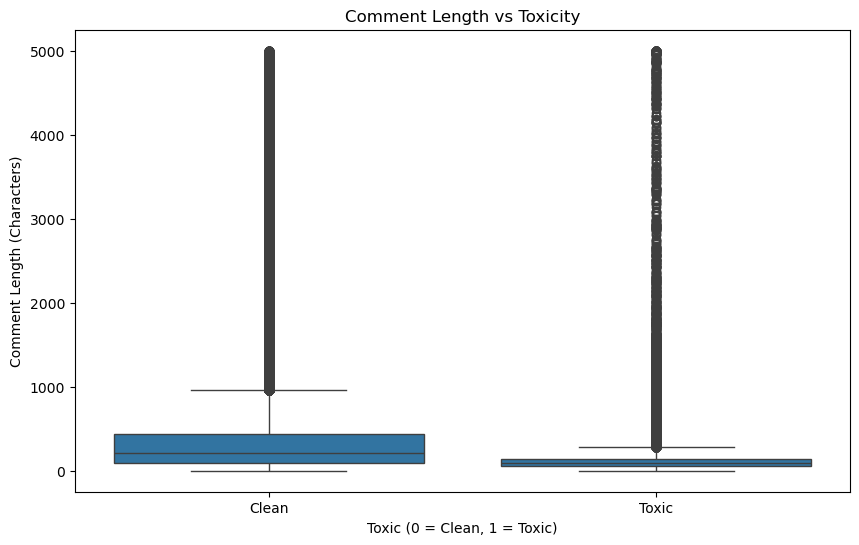

In [8]:
plot_length_vs_toxicity(df)

In [9]:
df['clean_text'] = df['comment_text'].apply(preprocess_text)

e:\POLYTEHNICA BUCHAREST\NLP_SSL_Project\Project\preprocess_data.py:108: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
e:\POLYTEHNICA BUCHAREST\NLP_SSL_Project\Project\preprocess_data.py:108: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [10]:
print(df.iloc[1, 1])
print(df.iloc[1, -1])

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
aww match background colour seemingly stuck thanks talk january utc


In [28]:
def train_lstm(X_train, Y_train, X_val, Y_val, max_words=20000, max_len=200):
    # Tokenize
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

    model = Sequential([
        Embedding(input_dim=max_words, output_dim=128),
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(6, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    f1_callback = F1ScoreCallback(X_val_pad, Y_val)

    history = model.fit(
        X_train_pad, Y_train,
        validation_data=(X_val_pad, Y_val),
        batch_size=128,
        epochs=5,
        callbacks=[EarlyStopping(patience=2, restore_best_weights=True), f1_callback]
    )

    plot_f1_history(f1_callback.f1_scores)
    
    return model, tokenizer, history

In [14]:
def evaluate_model(model, tokenizer, X_test, Y_test, max_len=200):
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

    y_pred_probs = model.predict(X_test_pad)
    y_pred = (y_pred_probs >= 0.5).astype(int)

    print(classification_report(Y_test, y_pred, target_names=Y_test.columns, zero_division=0))
    return y_pred

Epoch 1/5
1549/1549 [==============================] - 173s 107ms/step - loss: 0.0861 - accuracy: 0.9478 - val_loss: 0.0610 - val_accuracy: 0.9577

Epoch 1: val_f1_score: 0.4324
Epoch 2/5
1549/1549 [==============================] - 165s 106ms/step - loss: 0.0578 - accuracy: 0.9716 - val_loss: 0.0594 - val_accuracy: 0.9908

Epoch 2: val_f1_score: 0.4753
Epoch 3/5
1549/1549 [==============================] - 165s 106ms/step - loss: 0.0517 - accuracy: 0.9594 - val_loss: 0.0596 - val_accuracy: 0.9374

Epoch 3: val_f1_score: 0.4994
Epoch 4/5
1549/1549 [==============================] - 164s 106ms/step - loss: 0.0455 - accuracy: 0.9599 - val_loss: 0.0603 - val_accuracy: 0.9864

Epoch 4: val_f1_score: 0.4753


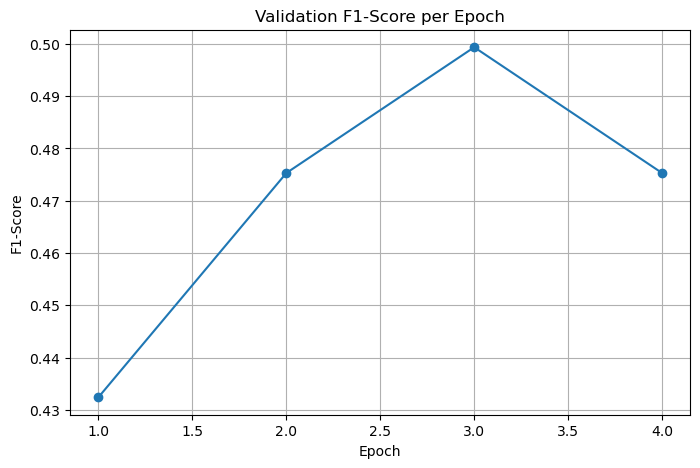

In [15]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_and_split(df)
model, tokenizer, history = train_lstm(X_train, Y_train, X_val, Y_val)

In [16]:
y_pred = evaluate_model(model, tokenizer, X_test, Y_test)

               precision    recall  f1-score   support

        toxic       0.89      0.82      0.86      4189
 severe_toxic       0.45      0.09      0.15       191
      obscene       0.94      0.84      0.89      3269
       threat       0.00      0.00      0.00        67
       insult       0.89      0.84      0.86      3168
identity_hate       0.59      0.04      0.08       388

    micro avg       0.90      0.79      0.84     11272
    macro avg       0.63      0.44      0.47     11272
 weighted avg       0.88      0.79      0.82     11272
  samples avg       0.13      0.12      0.13     11272



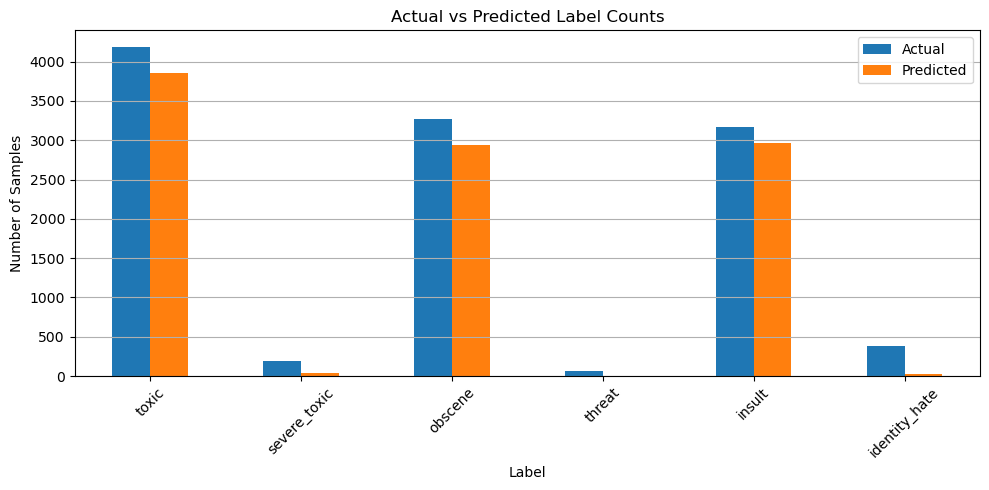

In [17]:
plot_actual_vs_predicted(Y_test, y_pred, Y_test.columns)

# With basic preprocessing

Train samples = 159571
Test cleaned samples = 63978


e:\POLYTEHNICA BUCHAREST\NLP_SSL_Project\Project\preprocess_data.py:108: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
e:\POLYTEHNICA BUCHAREST\NLP_SSL_Project\Project\preprocess_data.py:108: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Epoch 1/5
1553/1553 [==============================] - 173s 107ms/step - loss: 0.1523 - accuracy: 0.8096 - val_loss: 0.0780 - val_accuracy: 0.9953

Epoch 1: val_f1_score: 0.4232
Epoch 2/5
1553/1553 [==============================] - 165s 106ms/step - loss: 0.0695 - accuracy: 0.9924 - val_loss: 0.0900 - val_accuracy: 0.9955

Epoch 2: val_f1_score: 0.4169
Epoch 3/5
1553/1553 [==============================] - 165s 106ms/step - loss: 0.0624 - accuracy: 0.9947 - val_loss: 0.0687 - val_accuracy: 0.9955

Epoch 3: val_f1_score: 0.4343
Epoch 4/5
1553/1553 [==============================] - 165s 106ms/step - loss: 0.0592 - accuracy: 0.9949 - val_loss: 0.0678 - val_accuracy: 0.9955

Epoch 4: val_f1_score: 0.4355
Epoch 5/5
1553/1553 [==============================] - 165s 106ms/step - loss: 0.0570 - accuracy: 0.9952 - val_loss: 0.0665 - val_accuracy: 0.9955

Epoch 5: val_f1_score: 0.4401


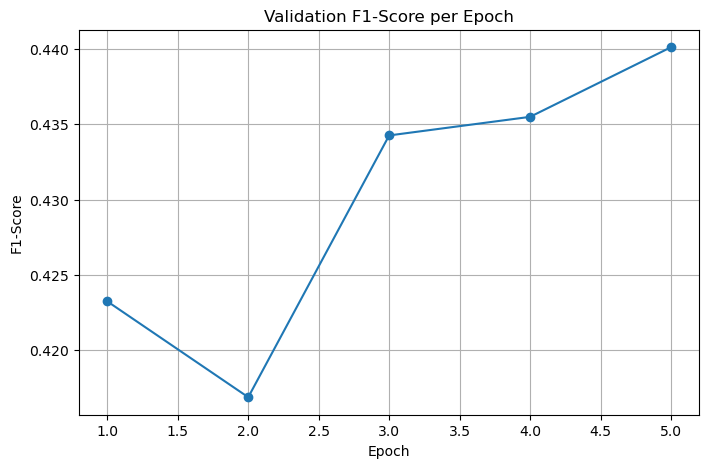

In [24]:
df_basic = load_data()
df_basic['clean_text'] = df_basic['comment_text'].apply(lambda x: preprocess_text(x, is_basic=True))
basic_X_train, basic_X_val, basic_X_test, basic_Y_train, basic_Y_val, basic_Y_test = prepare_and_split(df_basic)
model_basic, tokenizer_basic, history_basic = train_lstm(basic_X_train, basic_Y_train, basic_X_val, basic_Y_val)

In [25]:
basic_y_pred = evaluate_model(model_basic, tokenizer_basic, basic_X_test, basic_Y_test)

               precision    recall  f1-score   support

        toxic       0.91      0.81      0.86      4325
 severe_toxic       0.40      0.01      0.02       211
      obscene       0.92      0.86      0.89      3371
       threat       0.00      0.00      0.00        79
       insult       0.88      0.85      0.87      3255
identity_hate       0.00      0.00      0.00       372

    micro avg       0.90      0.79      0.84     11613
    macro avg       0.52      0.42      0.44     11613
 weighted avg       0.86      0.79      0.82     11613
  samples avg       0.14      0.13      0.13     11613



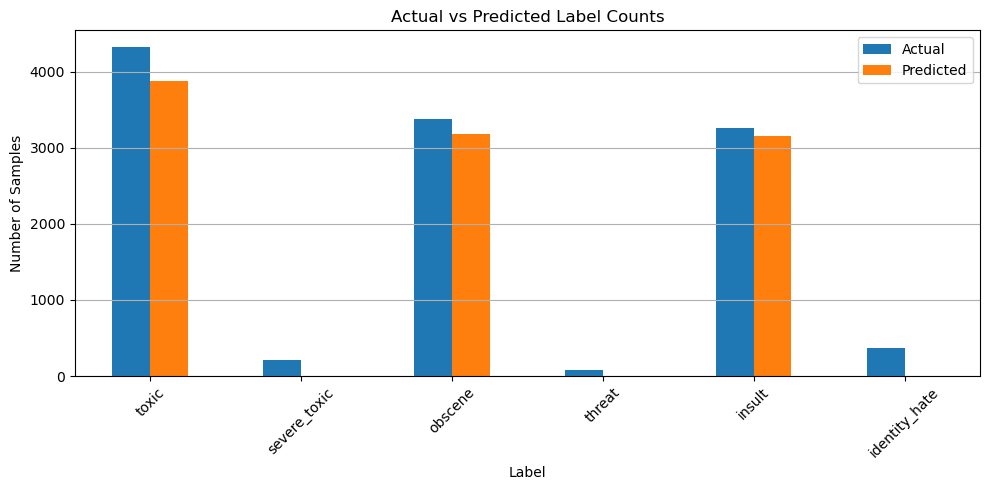

In [29]:
plot_actual_vs_predicted(basic_Y_test, basic_y_pred, basic_Y_test.columns)